In [ ]:
# STEP 1: Uninstall conflicting packages
!pip uninstall -y pydantic evidently numpy

# STEP 2: Install compatible versions
!pip install pydantic==1.10.13 evidently==0.4.11 numpy==1.24.4

# STEP 3: Restart the runtime
import os
os.kill(os.getpid(), 9)





Found existing installation: pydantic 1.10.13
Uninstalling pydantic-1.10.13:
  Successfully uninstalled pydantic-1.10.13
Found existing installation: evidently 0.4.11
Uninstalling evidently-0.4.11:
  Successfully uninstalled evidently-0.4.11
Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
  Using cached pydantic-1.10.13-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (149 kB)
  Using cached evidently-0.4.11-py3-none-any.whl.metadata (1.8 kB)
  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached pydantic-1.10.13-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
Using cached evidently-0.4.11-py3-none-any.whl (15.5 MB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behavi

In [5]:
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
import pandas as pd
import evidently

import kagglehub
import os
path = kagglehub.dataset_download("atharvasoundankar/global-cybersecurity-threats-2015-2024")
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
csv_path = os.path.join(path, csv_files[0])
print('Loaded CSV:', csv_path)
df = pd.read_csv(csv_path)


# Step 2: Simulate drift by splitting the data
ref_data = df.sample(frac=0.5, random_state=42)
curr_data = df.drop(ref_data.index)

# Step 3: Generate data drift report
report = Report(metrics=[DataDriftPreset()])
report.run(reference_data=ref_data, current_data=curr_data)

# Step 4: Save the report
report.save_html("drift_report.html")
print("✅ Drift report saved as 'drift_report.html'")


Loaded CSV: /root/.cache/kagglehub/datasets/atharvasoundankar/global-cybersecurity-threats-2015-2024/versions/1/Global_Cybersecurity_Threats_2015-2024.csv
✅ Drift report saved as 'drift_report.html'


In [8]:
from google.colab import files
files.download("drift_report.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
def detect_drift_statistically(ref_df, curr_df, threshold=0.1):
    drift_detected = False
    for col in ref_df.columns:
        if pd.api.types.is_numeric_dtype(ref_df[col]):
            ref_mean = ref_df[col].mean()
            curr_mean = curr_df[col].mean()
            rel_diff = abs(ref_mean - curr_mean) / (abs(ref_mean) + 1e-5)
            if rel_diff > threshold:
                print(f"[DRIFT] Feature '{col}' drifted: rel diff = {rel_diff:.2f}")
                drift_detected = True
    return drift_detected


# Live Data Simulator

In [24]:
!pip install kagglehub shap lime xgboost scikit-learn pandas numpy matplotlib evidently pyyaml loguru --quiet

import pandas as pd
import numpy as np
from datetime import datetime
import os
import sys
from loguru import logger
import yaml

CONFIG = {
    'data': {
        'features': ['feature_1', 'feature_2', 'feature_3'],
        'target_column': 'target',
        'raw_data_path': './raw_data/dummy_data.csv'
    },
    'paths': {
        'raw_data_dir': './raw_data'
    }
}

class DataHandler:
    def _create_dummy_data(self, num_samples=10):
        np.random.seed(42)
        df = pd.DataFrame({
            'feature_1': np.random.normal(0, 1, size=num_samples),
            'feature_2': np.random.randint(0, 100, size=num_samples),
            'feature_3': np.random.rand(num_samples),
            'target': np.random.randint(0, 2, size=num_samples)
        })
        return df

class LiveDataSimulator:
    def __init__(self, data_handler: DataHandler):
        self.data_handler = data_handler
        self.features = CONFIG['data']['features']
        self.target_column = CONFIG['data']['target_column']
        self.num_samples_per_batch = 5

    def generate_new_live_data_batch(self, include_actuals_ratio=0.5):
        logger.info(f"Simulating a batch of {self.num_samples_per_batch} new live data points.")
        dummy_df = self.data_handler._create_dummy_data(num_samples=self.num_samples_per_batch)
        new_raw_data_df = dummy_df[self.features].copy()
        actual_values_available = []

        for i in range(self.num_samples_per_batch):
            if np.random.rand() < include_actuals_ratio:
                actual_value = dummy_df.loc[i, self.target_column]
                actual_values_available.append((i, actual_value))

        logger.info(f"Generated {self.num_samples_per_batch} new data points. "
                    f"{len(actual_values_available)} with immediate actuals.")
        return new_raw_data_df, actual_values_available

dh = DataHandler()

# Create dummy data file if not exists
os.makedirs(CONFIG['paths']['raw_data_dir'], exist_ok=True)
dummy_path = CONFIG['data']['raw_data_path']
if not os.path.exists(dummy_path):
    dummy_df_init = dh._create_dummy_data(num_samples=200)
    dummy_df_init.to_csv(dummy_path, index=False)

# Simulate
simulator = LiveDataSimulator(dh)
new_data_batch, actuals_batch = simulator.generate_new_live_data_batch(include_actuals_ratio=0.8)

logger.info(f"Generated new data batch:\n{new_data_batch}")
logger.info(f"Actuals available in this batch: {actuals_batch}")


2025-07-24 15:48:05.952 | INFO     | __main__:generate_new_live_data_batch:41 - Simulating a batch of 5 new live data points.
2025-07-24 15:48:05.956 | INFO     | __main__:generate_new_live_data_batch:51 - Generated 5 new data points. 5 with immediate actuals.
2025-07-24 15:48:05.960 | INFO     | __main__:<cell line: 0>:68 - Generated new data batch:
   feature_1  feature_2  feature_3
0   0.496714         74   0.650888
1  -0.138264         74   0.056412
2   0.647689         87   0.721999
3   1.523030         99   0.938553
4  -0.234153         23   0.000779
2025-07-24 15:48:05.961 | INFO     | __main__:<cell line: 0>:69 - Actuals available in this batch: [(0, 1), (1, 0), (2, 0), (3, 1), (4, 1)]


# Monitoring and Troubleshooting Pipeline

MSE: 2.56, R2: 0.99


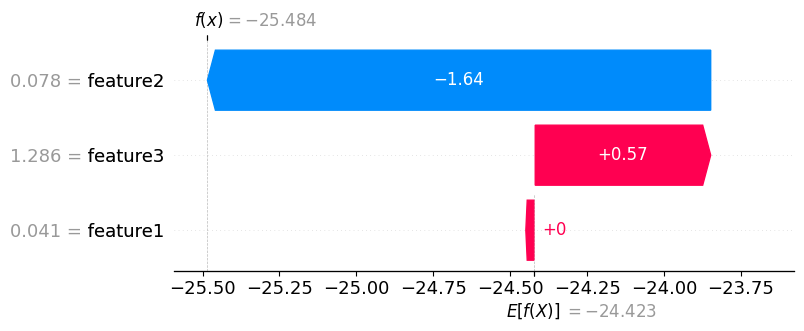

Intercept -26.654547751167215
Prediction_local [-14.28463568]
Right: -25.483995


In [25]:
import pandas as pd
import numpy as np
import time
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lime.lime_tabular import LimeTabularExplainer
import shap

# Simulated dummy dataset
def create_dummy_data(num_samples=200):
    np.random.seed(42)
    data = pd.DataFrame({
        'feature1': np.random.rand(num_samples),
        'feature2': np.random.rand(num_samples) * 50,
        'feature3': np.random.randint(1, 5, size=num_samples),
    })
    data['target'] = 10 + 2 * data['feature1'] - 1.5 * data['feature2'] + data['feature3'] + np.random.normal(0, 1, num_samples)
    return data

class MinimalCyberAI:
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = None
        self.X_train, self.X_test, self.y_train, self.y_test = [None]*4

    def prepare_data(self):
        df = create_dummy_data(200)
        X = df.drop(columns='target')
        y = df['target']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        self.X_train = pd.DataFrame(self.scaler.fit_transform(self.X_train), columns=X.columns)
        self.X_test = pd.DataFrame(self.scaler.transform(self.X_test), columns=X.columns)

    def train_model(self):
        self.model = xgb.XGBRegressor(n_estimators=100)
        self.model.fit(self.X_train, self.y_train)
        preds = self.model.predict(self.X_test)
        mse = mean_squared_error(self.y_test, preds)
        r2 = r2_score(self.y_test, preds)
        print(f"MSE: {mse:.2f}, R2: {r2:.2f}")

    def explain_with_shap(self):
        explainer = shap.Explainer(self.model, self.X_train)
        shap_values = explainer(self.X_test[:5])
        shap.plots.waterfall(shap_values[0])

    def explain_with_lime(self):
        explainer = LimeTabularExplainer(
            self.X_train.values,
            feature_names=self.X_train.columns.tolist(),
            verbose=True,
            mode="regression"
        )
        exp = explainer.explain_instance(
            self.X_test.iloc[0].values, self.model.predict
        )
        exp.show_in_notebook()



if __name__ == '__main__':
    ai = MinimalCyberAI()
    ai.prepare_data()
    ai.train_model()
    ai.explain_with_shap()
    ai.explain_with_lime()


# Main Orchestrator for Continuous AI Loop

✅ Packages loaded
[INFO] Initial Model MSE: 30.54
[INFO] ---- Running Live Predictions ----
[INFO] Pred: 67.79, Actual: 69.38
[INFO] Pred: 67.79, Actual: 69.38
[INFO] Pred: 67.79, Actual: 69.38
[INFO] Pred: 67.79, Actual: 69.38
[INFO] Pred: 67.79, Actual: 69.38
[INFO] Pred: 67.79, Actual: 69.38
[INFO] Pred: 67.79, Actual: 69.38
[INFO] Pred: 67.79, Actual: 69.38
[INFO] Pred: 67.79, Actual: 69.38
[INFO] Pred: 67.79, Actual: 69.38
[INFO] Pred: 67.79, Actual: 69.38
[INFO] Pred: 67.79, Actual: 69.38
[INFO] Pred: 67.79, Actual: 69.38
[INFO] Pred: 67.79, Actual: 69.38
[INFO] Pred: 67.79, Actual: 69.38
[INFO] Pred: 67.79, Actual: 69.38
[INFO] Pred: 67.79, Actual: 69.38
[INFO] Pred: 67.79, Actual: 69.38
[INFO] Pred: 67.79, Actual: 69.38
[INFO] Pred: 67.79, Actual: 69.38
[INFO] Collected feedback points: 20
[INFO] New model did not improve enough. Keeping old model.
[INFO] Generating SHAP explainability on 1 test instance


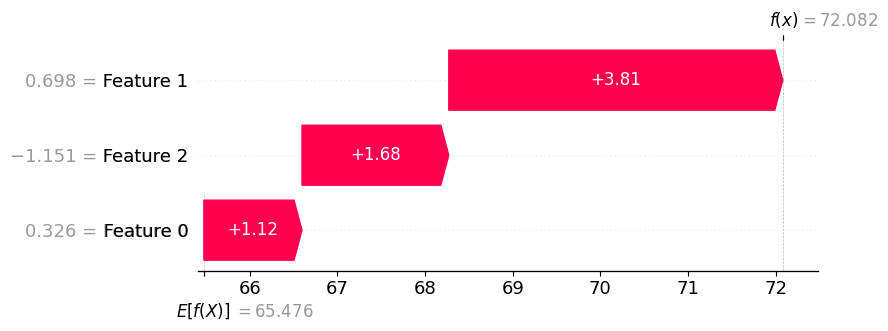

In [26]:
import numpy as np
import pandas as pd
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import shap
import warnings
warnings.filterwarnings("ignore")

print("✅ Packages loaded")

# ========== CONFIG & LOGGER ==========
CONFIG = {
    'data': {
        'features': ['feature1', 'feature2', 'feature3'],
        'numerical_features': ['feature1', 'feature2'],
        'target_column': 'loss',
    },
    'model': {
        'retrain_threshold': 10,
        'min_performance_improvement_for_deployment': 0.05,
    }
}

def logger(msg):
    print(f"[INFO] {msg}")

# ========== DUMMY DATA CREATION ==========
def create_dummy_data(num_samples=500):
    np.random.seed(42)
    X = pd.DataFrame({
        'feature1': np.random.normal(100, 20, num_samples),
        'feature2': np.random.normal(50, 10, num_samples),
        'feature3': np.random.choice(['low', 'medium', 'high'], size=num_samples)
    })
    X['feature3'] = X['feature3'].map({'low': 0, 'medium': 1, 'high': 2})
    y = X['feature1'] * 0.3 + X['feature2'] * 0.7 + np.random.normal(0, 5, num_samples)
    return X, y

X, y = create_dummy_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========== INITIAL MODEL TRAINING ==========
model = RandomForestRegressor()
model.fit(X_train_scaled, y_train)
current_mse = mean_squared_error(y_test, model.predict(X_test_scaled))
logger(f"Initial Model MSE: {current_mse:.2f}")

feedback_log = []

# ========== LIVE PREDICTION LOOP ==========
def simulate_live_data_point():
    X_new, y_new = create_dummy_data(num_samples=1)
    return X_new.iloc[0], y_new.iloc[0]

def predict_and_log(model, scaler, raw_point, actual_value=None):
    X_proc = scaler.transform([raw_point.values])
    pred = model.predict(X_proc)[0]
    feedback_log.append({
        'feature1': raw_point['feature1'],
        'feature2': raw_point['feature2'],
        'feature3': raw_point['feature3'],
        'predicted': pred,
        'actual': actual_value
    })
    return pred

logger("---- Running Live Predictions ----")
for _ in range(20):
    raw_point, actual = simulate_live_data_point()
    prediction = predict_and_log(model, scaler, raw_point, actual)
    logger(f"Pred: {prediction:.2f}, Actual: {actual:.2f}")
    time.sleep(0.2)

# ========== MONITORING & RETRAINING ==========
feedback_df = pd.DataFrame(feedback_log).dropna()
logger(f"Collected feedback points: {len(feedback_df)}")

if len(feedback_df) >= CONFIG['model']['retrain_threshold']:
    X_feedback = feedback_df[CONFIG['data']['features']]
    y_feedback = feedback_df['actual']
    X_fb_scaled = scaler.transform(X_feedback)

    X_combined = np.vstack([X_train_scaled, X_fb_scaled])
    y_combined = np.concatenate([y_train, y_feedback])

    new_model = RandomForestRegressor()
    new_model.fit(X_combined, y_combined)
    new_mse = mean_squared_error(y_test, new_model.predict(X_test_scaled))

    improvement = current_mse - new_mse
    if improvement > CONFIG['model']['min_performance_improvement_for_deployment'] * current_mse:
        logger(f"Model improved from {current_mse:.2f} to {new_mse:.2f}. Updating model.")
        model = new_model
        current_mse = new_mse
    else:
        logger("New model did not improve enough. Keeping old model.")

logger("Generating SHAP explainability on 1 test instance")
explainer = shap.Explainer(model.predict, X_test_scaled)
shap_values = explainer(X_test_scaled[:1])
shap.plots.waterfall(shap_values[0])


 # AI Tunin And Monitoring System
 # FOR SIMULATION - 20 EVENTS
  

MSE: 26.46, R2: 0.97


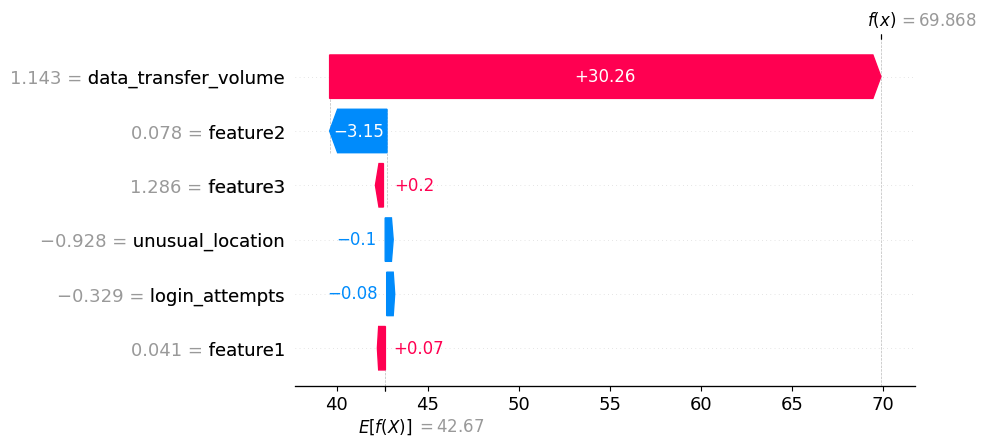

Intercept 27.423699940278702
Prediction_local [79.0673872]
Right: 69.867714


[INFO] Starting live simulation for 20 events (drift=False)...
[ALERT] Predicted: 1.42, Actual: -1.36, Why flagged: No specific anomaly detected
[ALERT] Predicted: 54.87, Actual: 57.86, Why flagged: No specific anomaly detected
[ALERT] Predicted: 22.67, Actual: 31.64, Why flagged: No specific anomaly detected
[ALERT] Predicted: 84.67, Actual: 92.62, Why flagged: No specific anomaly detected
[ALERT] Predicted: 36.26, Actual: 35.10, Why flagged: No specific anomaly detected
[ALERT] Predicted: 29.58, Actual: 34.54, Why flagged: No specific anomaly detected
[ALERT] Predicted: 98.26, Actual: 96.52, Why flagged: No specific anomaly detected
[ALERT] Predicted: 50.85, Actual: 49.02, Why flagged: No specific anomaly detected
[ALERT] Predicted: 42.26, Actual: 39.25, Why flagged: No specific anomaly detected
[ALERT] Predicted: 43.37, Actual: 39.91, Why flagged: No specific anomaly detected
[ALERT] Predicted: -3.85, Actual: 0.07, Why flagged: No specific anomaly detected
[ALERT] Predicted: 50.57, 

In [27]:
import pandas as pd
import numpy as np
import time
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lime.lime_tabular import LimeTabularExplainer
import shap

# Logger stub
def logger(level, msg):
    print(f"[{level.upper()}] {msg}")

# Simulated dummy dataset
def create_dummy_data(num_samples=200):
    np.random.seed(42)
    data = pd.DataFrame({
        'feature1': np.random.rand(num_samples),
        'feature2': np.random.rand(num_samples) * 50,
        'feature3': np.random.randint(1, 5, size=num_samples),
        'login_attempts': np.random.randint(1, 10, size=num_samples),
        'data_transfer_volume': np.random.randint(100, 500, size=num_samples),
        'unusual_location': np.random.choice([0, 1], size=num_samples)
    })
    data['target'] = (
        10 + 2 * data['feature1'] - 1.5 * data['feature2'] +
        data['feature3'] + 0.5 * data['login_attempts'] +
        0.2 * data['data_transfer_volume'] +
        3 * data['unusual_location'] + np.random.normal(0, 1, num_samples)
    )
    return data

class MinimalCyberAI:
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = None
        self.X_train, self.X_test, self.y_train, self.y_test = [None]*4
        self.live_monitoring_data = []
        self.feedback_buffer = []

    def prepare_data(self):
        df = create_dummy_data(200)
        X = df.drop(columns='target')
        y = df['target']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        self.X_train = pd.DataFrame(self.scaler.fit_transform(self.X_train), columns=X.columns)
        self.X_test = pd.DataFrame(self.scaler.transform(self.X_test), columns=X.columns)

    def train_model(self):
        self.model = xgb.XGBRegressor(n_estimators=100)
        self.model.fit(self.X_train, self.y_train)
        preds = self.model.predict(self.X_test)
        mse = mean_squared_error(self.y_test, preds)
        r2 = r2_score(self.y_test, preds)
        print(f"MSE: {mse:.2f}, R2: {r2:.2f}")

    def explain_with_shap(self):
        explainer = shap.Explainer(self.model, self.X_train)
        shap_values = explainer(self.X_test[:5])
        shap.plots.waterfall(shap_values[0])

    def explain_with_lime(self):
        explainer = LimeTabularExplainer(
            self.X_train.values,
            feature_names=self.X_train.columns.tolist(),
            verbose=True,
            mode="regression"
        )
        exp = explainer.explain_instance(
            self.X_test.iloc[0].values, self.model.predict
        )
        exp.show_in_notebook()

    def _generate_tooltip_explanation(self, instance_df):
        reasons = []
        if 'login_attempts' in instance_df.columns and instance_df['login_attempts'].values[0] > 5:
            reasons.append("High login attempts")
        if 'data_transfer_volume' in instance_df.columns and instance_df['data_transfer_volume'].values[0] > 200:
            reasons.append("Unusually high data transfer volume")
        if 'unusual_location' in instance_df.columns and instance_df['unusual_location'].values[0] == 1:
            reasons.append("Login from an unusual location")
        return "; ".join(reasons) if reasons else "No specific anomaly detected"

    def _create_synthetic_data(self, num_samples=50, is_drifted=False):
        df = create_dummy_data(num_samples)
        if is_drifted:
            df['feature2'] *= 1.5  # simulate drift
        X = df.drop(columns='target')
        y = df['target']
        X_scaled = pd.DataFrame(self.scaler.transform(X), columns=X.columns)
        return X_scaled, y

    def monitor_and_tune(self):
        logger("info", "Checking for drift (simulated)...")
        if len(self.feedback_buffer) >= 50:
            logger("warn", "Drift detected, retraining model...")
            new_data = pd.concat([x['features'] for x in self.feedback_buffer])
            new_target = [x['actual'] for x in self.feedback_buffer]
            self.model.fit(new_data, new_target)
            self.feedback_buffer.clear()
            logger("info", "Retraining complete.")

    def run_live_simulation(self, num_predictions=20, simulate_drift=False):
        logger("info", f"Starting live simulation for {num_predictions} events (drift={simulate_drift})...")
        X_live, y_live = self._create_synthetic_data(num_predictions, simulate_drift)

        for i in range(num_predictions):
            inst = X_live.iloc[[i]]
            pred = self.model.predict(inst)[0]
            actual = y_live.iloc[i]
            reason = self._generate_tooltip_explanation(inst)

            self.live_monitoring_data.append({'prediction': pred, 'actual': actual, 'reason': reason})
            self.feedback_buffer.append({'features': inst, 'actual': actual})

            print(f"[ALERT] Predicted: {pred:.2f}, Actual: {actual:.2f}, Why flagged: {reason}")
            time.sleep(0.05)

        self.monitor_and_tune()


if __name__ == '__main__':
    ai = MinimalCyberAI()
    ai.prepare_data()
    ai.train_model()
    ai.explain_with_shap()
    ai.explain_with_lime()
    ai.run_live_simulation()


# Simulate live prediction for 50 events

In [28]:
ai.run_live_simulation(num_predictions=50)


[INFO] Starting live simulation for 50 events (drift=False)...
[ALERT] Predicted: 40.92, Actual: 46.44, Why flagged: No specific anomaly detected
[ALERT] Predicted: 29.96, Actual: 26.75, Why flagged: No specific anomaly detected
[ALERT] Predicted: 6.66, Actual: 0.02, Why flagged: No specific anomaly detected
[ALERT] Predicted: -10.79, Actual: -10.87, Why flagged: No specific anomaly detected
[ALERT] Predicted: 32.83, Actual: 33.25, Why flagged: No specific anomaly detected
[ALERT] Predicted: -12.04, Actual: -9.40, Why flagged: No specific anomaly detected
[ALERT] Predicted: 59.72, Actual: 71.69, Why flagged: No specific anomaly detected
[ALERT] Predicted: 87.66, Actual: 94.99, Why flagged: No specific anomaly detected
[ALERT] Predicted: 102.90, Actual: 104.65, Why flagged: No specific anomaly detected
[ALERT] Predicted: 69.93, Actual: 65.84, Why flagged: No specific anomaly detected
[ALERT] Predicted: 39.05, Actual: 38.42, Why flagged: No specific anomaly detected
[ALERT] Predicted: 68

# Simulate live prediction for 100 events

In [29]:
ai.run_live_simulation(num_predictions=100)


[INFO] Starting live simulation for 100 events (drift=False)...
[ALERT] Predicted: 83.16, Actual: 93.53, Why flagged: No specific anomaly detected
[ALERT] Predicted: 35.59, Actual: 31.60, Why flagged: No specific anomaly detected
[ALERT] Predicted: 70.60, Actual: 58.25, Why flagged: No specific anomaly detected
[ALERT] Predicted: 61.56, Actual: 72.73, Why flagged: No specific anomaly detected
[ALERT] Predicted: 26.99, Actual: 19.20, Why flagged: No specific anomaly detected
[ALERT] Predicted: 49.30, Actual: 49.27, Why flagged: No specific anomaly detected
[ALERT] Predicted: 27.76, Actual: 23.77, Why flagged: No specific anomaly detected
[ALERT] Predicted: 34.20, Actual: 32.91, Why flagged: No specific anomaly detected
[ALERT] Predicted: 94.30, Actual: 84.95, Why flagged: No specific anomaly detected
[ALERT] Predicted: 35.21, Actual: 32.84, Why flagged: No specific anomaly detected
[ALERT] Predicted: 35.49, Actual: 18.14, Why flagged: No specific anomaly detected
[ALERT] Predicted: 77.9

In [30]:
!pip install schedule evidently shap --quiet

In [31]:
import schedule
import time
import pandas as pd
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
from sklearn.linear_model import LogisticRegression
import joblib


CONFIG = {
    'data': {
        'features': ['feature1', 'feature2', 'feature3'],
        'target': 'target_column_name'
    }
}

def check_drift_and_retrain():
    print("[INFO] Checking for data drift...")

    ref_data = pd.read_csv('reference.csv')
    curr_data = pd.read_csv('current.csv')

    report = Report(metrics=[DataDriftPreset()])
    report.run(reference_data=ref_data, current_data=curr_data)
    drift_json = report.as_dict()

    drift_detected = drift_json['metrics'][0]['result']['dataset_drift']
    print("Drift detected:", drift_detected)

    if drift_detected:
        print("[ACTION] Drift detected. Retraining model.")
        X_curr = curr_data[CONFIG['data']['features']]
        y_curr = curr_data[CONFIG['data']['target']]
        model = LogisticRegression()
        model.fit(X_curr, y_curr)
        joblib.dump(model, 'model.pkl')
        print("[INFO] Model retrained and saved.")
    else:
        print("[INFO] No drift detected. Skipping retraining.")

# Schedule the task (will run once per minute here for testing, change time if needed)
schedule.every(1).minutes.do(check_drift_and_retrain)

# SAFE: Loop only for 5 minutes (instead of infinite)
start_time = time.time()
max_duration = 300  # Run for 5 minutes (300 sec)

while time.time() - start_time < max_duration:
    schedule.run_pending()
    time.sleep(5)  # Small sleep to reduce CPU load


[INFO] Checking for data drift...
Drift detected: False
[INFO] No drift detected. Skipping retraining.
[INFO] Checking for data drift...
Drift detected: False
[INFO] No drift detected. Skipping retraining.
[INFO] Checking for data drift...
Drift detected: False
[INFO] No drift detected. Skipping retraining.
[INFO] Checking for data drift...
Drift detected: False
[INFO] No drift detected. Skipping retraining.


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import shap


selected_cols = [
    'Financial Loss (in Million $)',
    'Number of Affected Users',
    'Incident Resolution Time (in Hours)',
    'Country',
    'Attack Type',
    'Attack Source',
    'Security Vulnerability Type'
]

data = df[selected_cols].copy()

# Label Encoding
label_encoders = {}
for col in ['Country', 'Attack Type', 'Attack Source', 'Security Vulnerability Type']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Standard Scaling
numerical_cols = ['Financial Loss (in Million $)', 'Number of Affected Users', 'Incident Resolution Time (in Hours)']
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Anomaly Detection
iso_model = IsolationForest(contamination=0.05, random_state=42)
data['Anomaly'] = iso_model.fit_predict(data.drop('Financial Loss (in Million $)', axis=1))
data['Anomaly'] = data['Anomaly'].map({1: 'Normal', -1: 'Anomaly'})
print(data['Anomaly'].value_counts())

# Split features and target
features = data.drop(columns=['Financial Loss (in Million $)', 'Anomaly'])
target = data['Financial Loss (in Million $)']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Model evaluation function
def evaluate_model(name, model):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{name}: MSE={mse:.2f}, R2={r2:.3f}")
    return (name, model, mse, r2)

# Models to evaluate
models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('XGBoost', XGBRegressor(n_estimators=100, random_state=42, verbosity=0))
]

# Evaluate all models
results = [evaluate_model(n, m) for n, m in models]
results.sort(key=lambda x: x[2])  # sort by MSE (lower is better)
best_name, best_model, _, _ = results[0]
print(f"Best Model: {best_name}")

# Use SHAP to explain the best model predictions
explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)

# Function to get top contributing feature
def get_reason(row_idx):
    row_values = shap_values.values[row_idx]
    top_feature_idx = np.argmax(np.abs(row_values))
    feature_name = X_test.columns[top_feature_idx]
    contribution = row_values[top_feature_idx]
    direction = "increased" if contribution > 0 else "decreased"
    return f"{feature_name} {direction} the risk"

# Create dataframe with predictions and flag reasons
df_val = X_test.copy()
df_val['predicted'] = best_model.predict(X_test)
df_val['flag_reason'] = [get_reason(i) for i in range(len(X_test))]

# Show result
print(df_val.head())


Anomaly
Normal     2850
Anomaly     150
Name: count, dtype: int64
Linear Regression: MSE=0.98, R2=-0.004
Random Forest: MSE=1.06, R2=-0.085
Gradient Boosting: MSE=1.00, R2=-0.021
XGBoost: MSE=1.27, R2=-0.301
Best Model: Linear Regression
      Number of Affected Users  Incident Resolution Time (in Hours)  Country  \
1801                  1.116294                             1.338238        0   
1190                  1.521971                             1.435480        0   
1817                  0.678995                            -1.287284        1   
251                   0.988858                            -0.217627        7   
2505                  1.428554                             1.046514        0   

      Attack Type  Attack Source  Security Vulnerability Type  predicted  \
1801            2              1                            2  -0.046808   
1190            1              1                            2  -0.039951   
1817            4              1                     

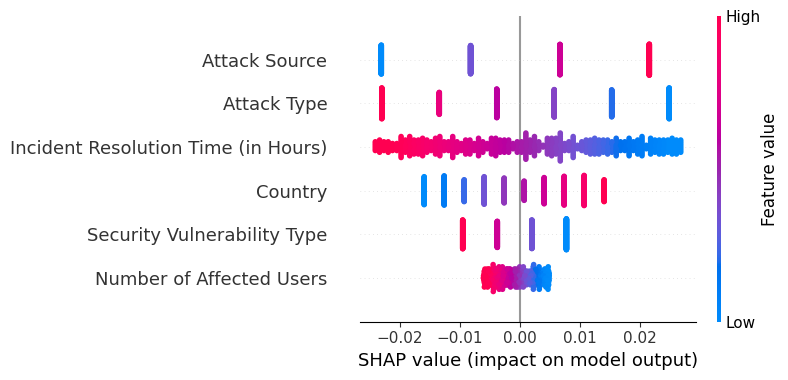

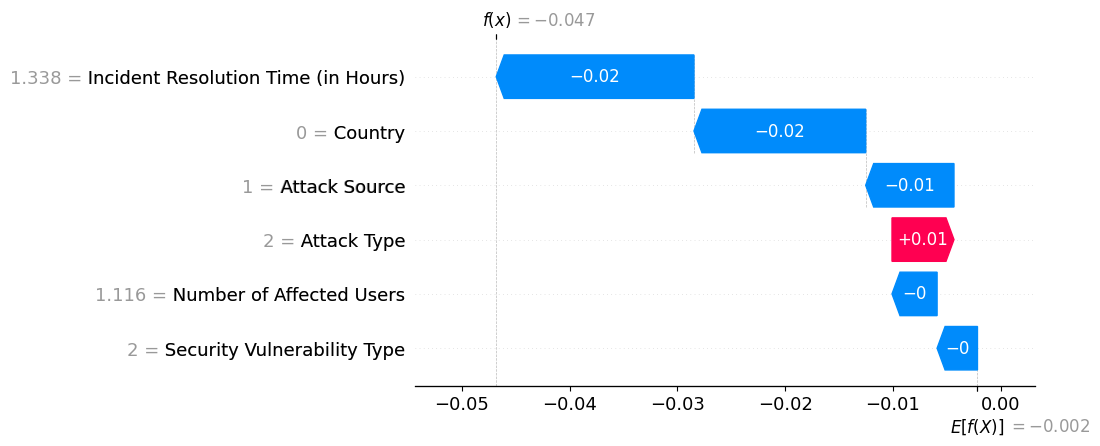

In [35]:
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)
shap.plots.waterfall(shap_values[0])



--- Explaining Specific Instances with LIME ---

📄 LIME Explanation for Instance 0 (Feature → Contribution):
Attack Source <= 1.00                    → -0.03
Incident Resolution Time (in Hours) > 0.90 → -0.03
Country <= 2.00                          → -0.02
Number of Affected Users > 0.87          → -0.01
1.00 < Security Vulnerability Type <= 2.00 → -0.00


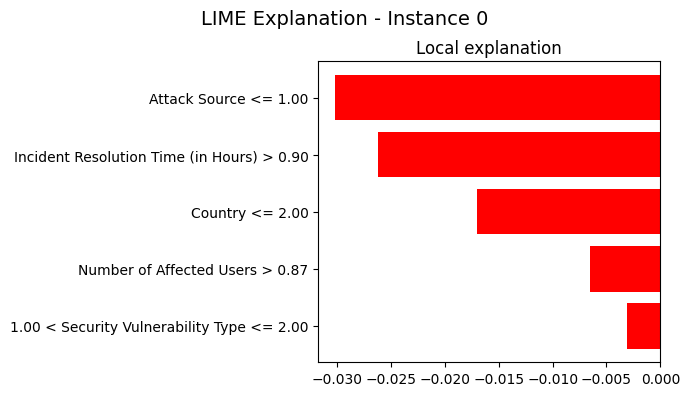


🔷 Model Predicted Financial Loss: $-0.05 Million

📄 LIME Explanation for Instance 5 (Feature → Contribution):
Attack Source <= 1.00                    → -0.03
Security Vulnerability Type <= 1.00      → +0.01
-0.85 < Incident Resolution Time (in Hours) <= 0.03 → +0.01
2.00 < Country <= 5.00                   → -0.00
-0.01 < Number of Affected Users <= 0.87 → -0.00


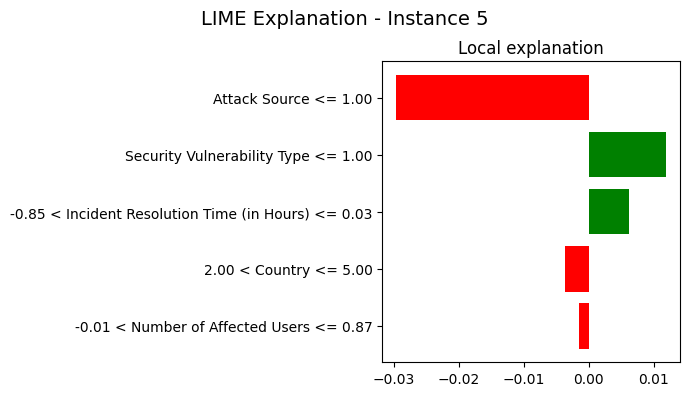


🔷 Model Predicted Financial Loss: $0.01 Million


In [37]:
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    mode='regression'
)

def explain_lime_instance(instance_idx, model, X_test, explainer):
    instance = X_test.iloc[instance_idx]
    lime_exp = explainer.explain_instance(
        data_row=instance.values,
        predict_fn=model.predict,
        num_features=5
    )
    print(f"\n📄 LIME Explanation for Instance {instance_idx} (Feature → Contribution):")
    for feature, value in lime_exp.as_list():
        print(f"{feature:40} → {value:+.2f}")
    fig = lime_exp.as_pyplot_figure()
    fig.set_size_inches(7, 4)
    fig.suptitle(f"LIME Explanation - Instance {instance_idx}", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    model_pred = model.predict(pd.DataFrame([instance], columns=X_test.columns))[0]
    print(f"\n🔷 Model Predicted Financial Loss: ${model_pred:.2f} Million")

print("\n--- Explaining Specific Instances with LIME ---")
explain_lime_instance(0, best_model, X_test, lime_explainer)
explain_lime_instance(5, best_model, X_test, lime_explainer)
